In [2]:
%%capture
!pip install category_encoders==2.*
!pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [4]:
url = 'https://raw.githubusercontent.com/Mralston17/StudentPerformanceData/main/StudentPerformanceFactors.csv'
df = pd.read_csv(url)
df = df.dropna(how='any', axis = 0)
df = df.drop(columns= ['Gender', 'Sleep_Hours','School_Type', 'Internet_Access', 'Physical_Activity', 'Distance_from_Home'])

array([[<Axes: title={'center': 'Hours_Studied'}>,
        <Axes: title={'center': 'Attendance'}>],
       [<Axes: title={'center': 'Previous_Scores'}>,
        <Axes: title={'center': 'Tutoring_Sessions'}>],
       [<Axes: title={'center': 'Exam_Score'}>, <Axes: >]], dtype=object)

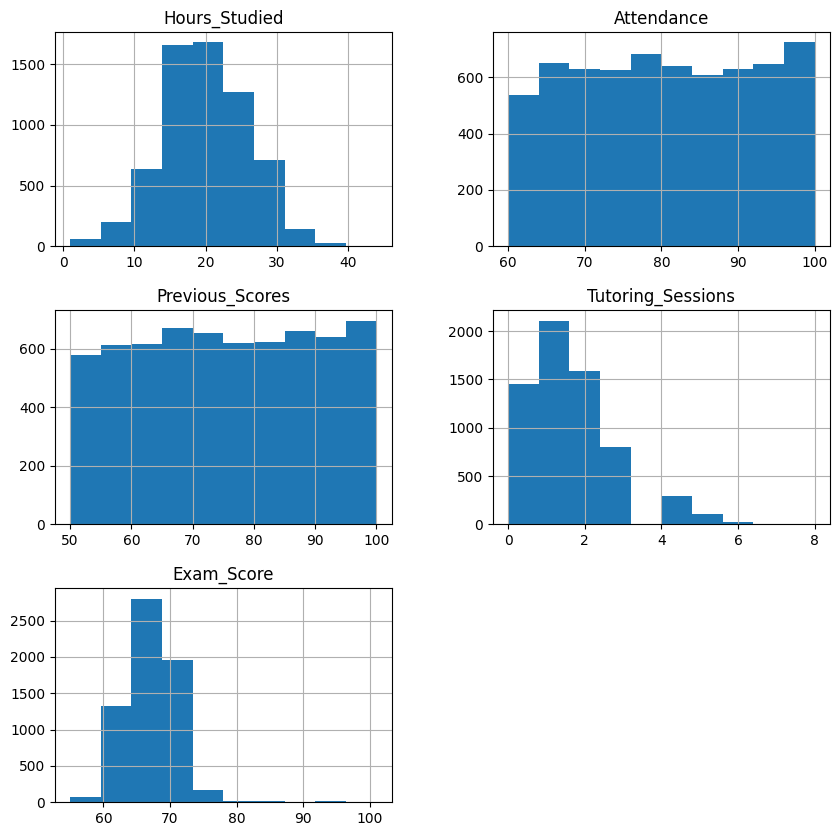

In [5]:
df.head(10)
df.hist(figsize=(10,10))
#Most columns need encoding (done in the pipeline)

In [6]:
X = df.drop(columns='Exam_Score')
y = df['Exam_Score']

In [7]:
y_pred = [y.mean()] * len(y)
baseline_mae = skl.mean_absolute_error(y, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 2.859304989782906


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [9]:
model_lr = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    LinearRegression(),
)

In [10]:
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mae_lr = skl.mean_absolute_error(y_test, y_pred_lr)
r2_train_lr = model_lr.score(X_train, y_train)
r2_test_lr = model_lr.score(X_test, y_test)
print('Training R^2', r2_train_lr)
print('Testing R^2', r2_test_lr)
print('Baseline MAE:', baseline_mae)
print('MAE', mae_lr)

Training R^2 0.6579525770284391
Testing R^2 0.6783700851085268
Baseline MAE: 2.859304989782906
MAE 1.0098470135242612


<Axes: xlabel='Exam_Score'>

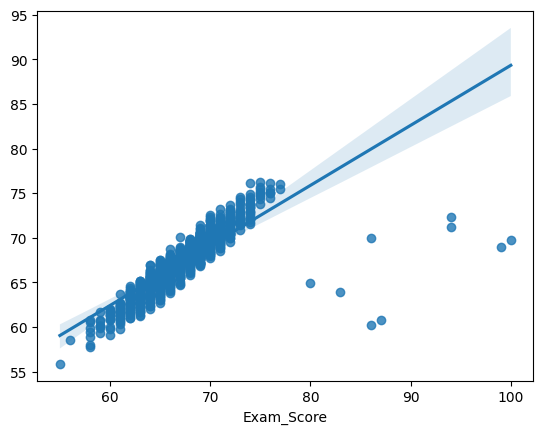

In [11]:
sns.regplot(x=y_test, y=y_pred_lr)

In [12]:
model_rfr = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    RandomForestRegressor(n_estimators= 100, random_state = 42, n_jobs = -1),
)

In [13]:
model_rfr.fit(X_train, y_train)
y_pred_rfr = model_rfr.predict(X_test)
mae_rfr = skl.mean_absolute_error(y_test, y_pred_rfr)
r2_train_rfr = model_rfr.score(X_train, y_train)
r2_test_rfr = model_rfr.score(X_test, y_test)
print('Training R^2', r2_train_rfr)
print('Testing R^2', r2_test_rfr)
print('Baseline MAE:', baseline_mae)
print('MAE', mae_rfr)

Training R^2 0.9480609118869324
Testing R^2 0.6067702473080251
Baseline MAE: 2.859304989782906
MAE 1.2069592476489028


<Axes: xlabel='Exam_Score'>

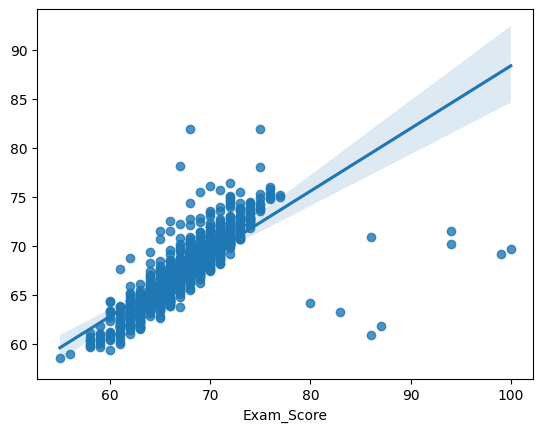

In [14]:
sns.regplot(x=y_test, y=y_pred_rfr)

In [15]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBRegressor(n_estimators= 20, max_depth = 4, random_state = 42, n_jobs = -1),
)
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Parental_Involvement',
                                      'Access_to_Resources',
                                      'Extracurricular_Activities',
                                      'Motivation_Level', 'Family_Income',
                                      'Teacher_Quality', 'Peer_Influence',
                                      'Learning_Disabilities',
                                      'Parental_Education_Level'],
                                mapping=[{'col': 'Parental_Involvement',
                                          'data_type': dtype('O'),
                                          'mapping': Low       1
High      2
Medium    3
NaN      -2
dtype:...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=20, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [16]:
param_grid = {
    'xgbregressor__lambda':range(0,5,1),
    'xgbregressor__alpha':range(0,5,1),
}

In [17]:
#model_xgb_gs = GridSearchCV(model_xgb, param_grid = param_grid, n_jobs = -1, cv = 3, verbose = 1)
#model_xgb_gs.fit(X_train, y_train)

In [18]:
#model_xgb_gs.best_params_

In [19]:
y_pred_xgb = model_xgb.predict(X_test)
mae_xgb = skl.mean_absolute_error(y_test, y_pred_xgb)
r2_train_xgb = model_xgb.score(X_train, y_train)
r2_test_xgb = model_xgb.score(X_test, y_test)
print('Training R^2', r2_train_xgb)
print('Testing R^2', r2_test_xgb)
print('Baseline MAE:', baseline_mae)
print('MAE', mae_xgb)

Training R^2 0.7325783967971802
Testing R^2 0.6722675561904907
Baseline MAE: 2.859304989782906
MAE 1.0005834932237583


<Axes: xlabel='Exam_Score'>

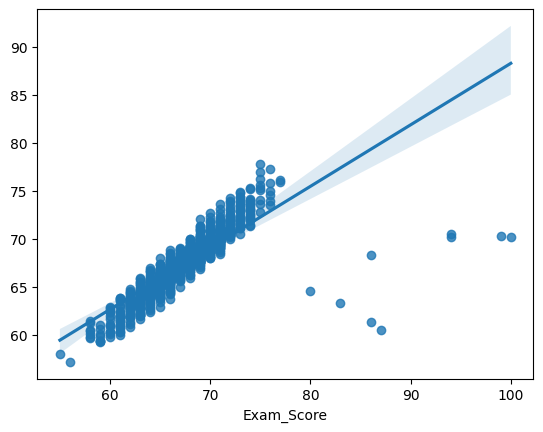

In [20]:
sns.regplot(x=y_test, y=y_pred_xgb)

<Axes: >

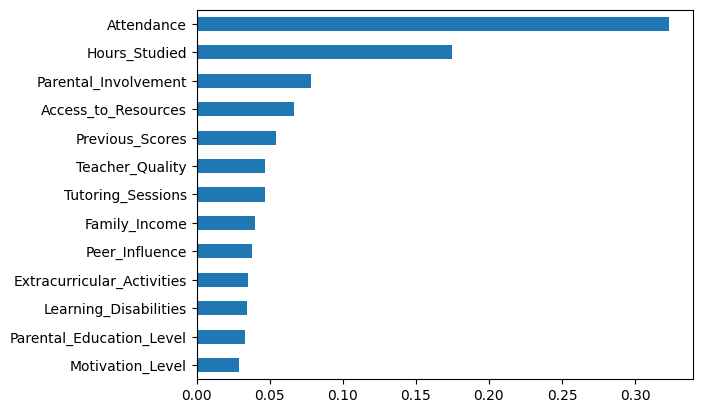

In [21]:
importances = model_xgb.named_steps['xgbregressor'].feature_importances_
feat_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feat_names).sort_values()
feat_imp.tail(19).plot(kind='barh')

In [22]:
perm_imp = permutation_importance(model_xgb, X_train, y_train, random_state=42)

In [23]:
data_perm ={'imp_mean':perm_imp['importances_mean'],
            'imp_std':perm_imp['importances_std']
}
df_perm = pd.DataFrame(data_perm, index= X_train.columns).sort_values('imp_mean')

<Axes: >

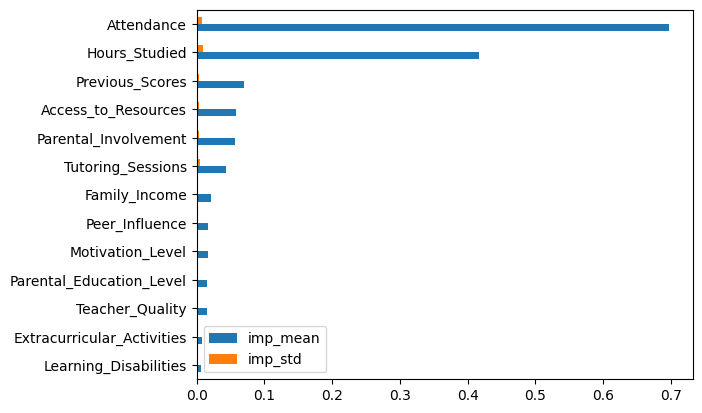

In [24]:
df_perm.plot(kind='barh')

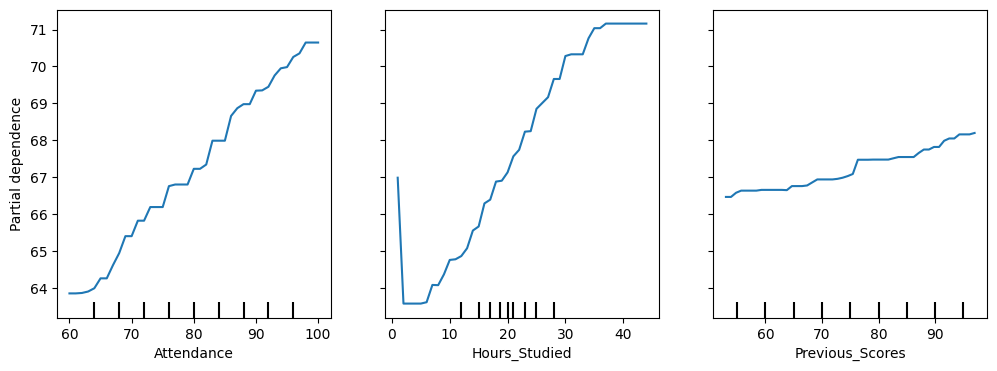

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(model_xgb, feature_names=X.columns, features=['Attendance', 'Hours_Studied', 'Previous_Scores'], X=X, grid_resolution= 50, ax=ax)

In [26]:
oe = OrdinalEncoder()
X_train = oe.fit_transform(X_train)
X_test = oe.fit_transform(X_test)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)
xgb = XGBRegressor(n_estimators= 20, max_depth = 4, random_state = 42, n_jobs = -1)
model_xgb = xgb.fit(X_train, y_train)

In [27]:
shap_ex = shap.TreeExplainer(model_xgb)
shap_values = shap_ex.shap_values(X_train)
shap.initjs()
shap.force_plot(shap_ex.expected_value, shap_values[25,:], X.iloc[25,:])